# Trends in Severe Weather Events in the United States
### Lately there has been considerable attention amongst climate scientists given to the seemingly growing unpredicatbility of the climate. Many scientists assert that anthropogenic  climate change is responsible for an increase of "severe" weather events. In this project, I will explore directly whether this perveived increase in frequency corresponds with an increase economic damage due these climate events. For the purposes of this project, property damage, crop damage, and number of deaths will be used to determine the 'economic severity' of weather events.

In [1]:
#importing all necessary libraries
import pandas as pd
import scipy
import requests
from bs4 import BeautifulSoup
import wget
import os
import glob
import warnings
warnings.filterwarnings('ignore')

import quandl

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import chart_studio.plotly as py

# 1. Reading in Data

## 1(a) NOAA Weather Event Data
### Using BeautifulSoup I will scrape the file names of all the weather data files we need from the NOAA website: https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/. From there, I will use python's wget library to download each of those files and store them in the 'data' folder using a more easily understood naming convention (year). Finally, the files will be read and combined into a single DataFrame.
### The following cell only needs to be run once. If the 'data' folder and properly named files are already in the working directory, there is no need to run this first cell. 
### The purpose of this cell is purely to automate the data collection process. Of course, you could always dowload all of these files from the NOAA website by hand, but what's the fun in that?

In [5]:
#######SKIP THIS CELL IF FILES ALREADY LOADED IN FILE SYSTEM######

def scrape_filenames(url):
    """A function to scrape the names of all the files from the NOAA html page.
    """
    website = requests.get(url)
    content = website.content
    soup = BeautifulSoup(content,features="html.parser")
    
    #finds the table with all of the file names and links
    table = soup.find_all('table')[0]
    table_rows = table.find_all('tr')
    
    #iterates throuh each row in the html table and selects the column 0 value in each row, which is the file name.
    file_names = []
    for tr in table_rows: #gets the data from each tr, essentially getting the stats for each year
        row_values = [td.get_text() for td in tr] # creates a list of each data entry in the given table row
        file_name = row_values[0]
        file_names.append(file_name)
        
    #returns the 'details' files, the only ones we need for this project
    filtered_filenames = list(filter(lambda name: "details" in name, file_names))
    return filtered_filenames

def download_files(file_names, website_url):
    """Downloads all of the compressed csv files for each year data was collected
    """
    #downloads all the files with the specified filenames and url and names the files by year. Takes advantage of 
    #the fact that the data in the html table is already sorted by year.
    year = 1950
    for name in file_names:
        
        #checks to see if the file already exists. If it does it deletes the old verion and downloads the new
        if os.path.isfile('./data/{}.csv.gz'.format(year)):
            os.remove('./data/' + name)
            file = wget.download(website_url + name, out='./data/{}.csv.gz'.format(year))
            year += 1
            
        #downloads the file when it doesn't already exist.
        else:
            file = wget.download(website_url + name, out='./data/{}.csv.gz'.format(year))
            year += 1
        
        
def get_data(url):
    #scrapes the file names and downloads the files using the two functions defined above. 
    file_names = scrape_filenames(url)
    download_files(file_names, url)

    
url = r'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
get_data(url)

In [2]:
#Loading the data into pandas DataFrames. This cell takes some time to run, so after this cell I copy the DataFrame
#so I don't have to keep running this cell if I need to reset the dataframe.

file_names = glob.glob("./data/*.csv.gz") #gets the name of all of the files compressed csv files in the data folder
years = [name[7:11] for name in file_names] #selects the year from each of the filenames

full_df = pd.DataFrame()

#creates a dataframe for the year of data being read in, adds a column indicating the year, then concatenates it to the 
#master dataframe. 
for i in range(len(file_names)):
    df = pd.read_csv(file_names[i], compression="gzip")
    df['Year'] = years[i]
    full_df = pd.concat([full_df, df])

full_df.head()

BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  END_YEARMONTH  END_DAY  END_TIME  \
0           196904          9        1600         196904        9      1600   
1           196909          6        1815         196909        6      1815   
2           196907         16        1850         196907       16      1850   
3           196905         29        1700         196905       29      1700   
4           196906         28         635         196906       28       635   

   EPISODE_ID  EVENT_ID     STATE  STATE_FIPS  ...  END_AZIMUTH END_LOCATION  \
0         NaN   9984356  ARKANSAS         5.0  ...          NaN          NaN   
1         NaN  10037132  KENTUCKY        21.0  ...          NaN          NaN   
2         NaN  10067849  NEBRASKA        31.0  ...          NaN          NaN   
3         NaN  10076065  NEW YORK        36.0  ...          NaN          NaN   
4         NaN  10057764  MISSOURI        29.0  ...          NaN          NaN   

  BEGIN_LAT BEGIN_LON  END_LAT END_LON EPISODE_NARRATIVE EVENT_NARRATIVE  \
0     36.00    -93.18      NaN     NaN               NaN             NaN   
1     36.88    -88.58      NaN     NaN               NaN             NaN   
2     41.70    -98.40      NaN     NaN               NaN             NaN   
3     42.08    -76.00      NaN     NaN               NaN             NaN   
4     38.78    -94.58      NaN     NaN               NaN             NaN   

  DATA_SOURCE  Year  
0         PUB  1969  
1         PUB  1969  
2         PUB  1969  
3         PUB  1969  
4         PUB  1969  

[5 rows x 52 columns]

In [3]:
#A look at all of the columns
master_df = full_df.copy()
print(master_df.columns)

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE', 'Year'],
      dtype='object')


## 1(b)  Reading in the Scripps Institute CO2 data
### The CO2 data was taken from: https://scrippsco2.ucsd.edu/data/atmospheric_co2/ljo.html. It contains the monthly CO2 readings for the La Jolla Pier Samplig Station. This dataset was chosen because of its was the most complete dataset of samples that occured in the contiguous United States.

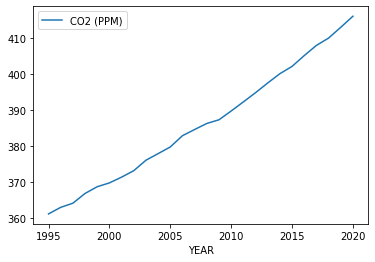

In [4]:
#reading in the csv from the data folder. The data starts on the 57th row
co2_data = pd.read_csv('data/monthly_flask_co2_ljo.csv', skiprows=56)

# the first two rows are just heading
co2_data = co2_data.iloc[2:]


co2_data = co2_data.astype('float')
co2_data['  Yr'] = co2_data['  Yr'].astype('int64')

#renaming the columns I want to select, selecting data from 1995 or after, and aggregating the CO2 level by year. 
co2_data.columns = ['YEAR', ' Mn', 'Date', 'Date2', '     CO2', 'seasonally',
       '        fit', '  seasonally', 'CO2 (PPM)', ' seasonally']
co2_data = co2_data[co2_data['YEAR'] >= 1995]
co2_by_year = co2_data.groupby('YEAR', as_index=False).mean()
co2_by_year = co2_by_year[['YEAR', 'CO2 (PPM)']]

#quckly analyze the data to see the trend
co2_by_year.plot(x='YEAR', y='CO2 (PPM)')

# 2. Cleaning and Preprocessing the Weather Event Data:
## The main things  to accomplish here are: Selecting the data we want, making sure the numeric data is formatted the way we want, adjusting the monetary values for inflation,  creating a singular variable to assess the economic impact of a particular weather event, and combining weather events that are listed separately but are actually part of the same event.

In [5]:
#Taking a look at the dimesnions of the dataset
master_df.shape

(1642260, 52)

## 2(a) Formatting the numeric and date columns, and selecting data after 1995.

In [6]:
#Splitting up 'BEGIN_YEARMONTH' to year and month
master_df['BEGIN_YEARMONTH'] = master_df['BEGIN_YEARMONTH'].astype(str)
master_df['BEGIN_YEAR'] = pd.to_numeric(master_df['BEGIN_YEARMONTH'].str[0:4])
master_df['BEGIN_MONTH'] = pd.to_numeric(master_df['BEGIN_YEARMONTH'].str[4:])
master_df.head()

BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  END_YEARMONTH  END_DAY  END_TIME  \
0          196904          9        1600         196904        9      1600   
1          196909          6        1815         196909        6      1815   
2          196907         16        1850         196907       16      1850   
3          196905         29        1700         196905       29      1700   
4          196906         28         635         196906       28       635   

   EPISODE_ID  EVENT_ID     STATE  STATE_FIPS  ...  BEGIN_LAT BEGIN_LON  \
0         NaN   9984356  ARKANSAS         5.0  ...      36.00    -93.18   
1         NaN  10037132  KENTUCKY        21.0  ...      36.88    -88.58   
2         NaN  10067849  NEBRASKA        31.0  ...      41.70    -98.40   
3         NaN  10076065  NEW YORK        36.0  ...      42.08    -76.00   
4         NaN  10057764  MISSOURI        29.0  ...      38.78    -94.58   

  END_LAT END_LON  EPISODE_NARRATIVE EVENT_NARRATIVE DATA_SOURCE  Year  \
0     NaN     NaN                NaN             NaN         PUB  1969   
1     NaN     NaN                NaN             NaN         PUB  1969   
2     NaN     NaN                NaN             NaN         PUB  1969   
3     NaN     NaN                NaN             NaN         PUB  1969   
4     NaN     NaN                NaN             NaN         PUB  1969   

  BEGIN_YEAR BEGIN_MONTH  
0       1969           4  
1       1969           9  
2       1969           7  
3       1969           5  
4       1969           6  

[5 rows x 54 columns]

In [7]:
#The first thing to do is get rid of the years we don't need. We will get rid of everything before 1995, since
#most types of weather events weren't recorded until after that.

master_df = master_df[master_df['BEGIN_YEAR'] >= 1995]
master_df.shape

(1430479, 54)

In [8]:
#converting the units in the DAMAGES column from strings to numeric values with the correct units.

def get_units(string):
    if string[-1] == "K":
        return 1000
    elif string[-1] == "M":
        return 1000000
    elif string[-1] == "B":
        return 1000000000
    else:
        return 0
    

master_df['DAMAGE_PROPERTY'] = master_df['DAMAGE_PROPERTY'].astype(str)
#creating a column with the units based on the last letter in the property column
master_df['PROPERTY_UNITS'] = master_df['DAMAGE_PROPERTY'].apply(get_units)

In [9]:
#removes the letters from the DAMAGE_PROPERTY column
def remove_letters(string):
    if string[-1] == "K" or string[-1] == "M" or string[-1] == "B":
        return string[:-1]
    else:
        return string
    
#convert the DAMAGE_PROPERTY column to its absolute numeric value  by multiplying the numeric col. by the units col.  
master_df['DAMAGE_PROPERTY'] = master_df['DAMAGE_PROPERTY'].astype(str).apply(remove_letters)
master_df['DAMAGE_PROPERTY'] = pd.to_numeric(master_df['DAMAGE_PROPERTY'], errors='coerce') * pd.to_numeric(master_df['PROPERTY_UNITS'], errors='coerce')

In [10]:
#Thhis cell does the same as the one above but for the DAMAGE_CROPS column
master_df['DAMAGE_CROPS'] = master_df['DAMAGE_CROPS'].astype(str)
master_df['CROPS_UNITS'] = master_df['DAMAGE_CROPS'].apply(get_units)

master_df['DAMAGE_CROPS'] = master_df['DAMAGE_CROPS'].astype(str).apply(remove_letters)
master_df['DAMAGE_CROPS'] = pd.to_numeric(master_df['DAMAGE_CROPS'], errors='coerce') * pd.to_numeric(master_df['CROPS_UNITS'], errors='coerce')

## 2(b) Adjusting the Property Damages and Crop Damages for inflation using the Consumer Price Index

In [11]:
#I will be fetching the CPI using a python API called quandl. To use this API I had register and create a free API key.
#I changed my API key after publishing this project, so running this cell with this API key WILL RETURN AN ERROR.

cpi_data = quandl.get("RATEINF/CPI_USA", api_key='rEu8n6m9G_ytM94NFpib')
cpi_df = pd.DataFrame(cpi_data)
cpi_df = cpi_df.reset_index()
cpi_df['Date'] = cpi_df['Date'].astype(str)
cpi_df.head()

Date  Value
0  1913-01-31    9.8
1  1913-02-28    9.8
2  1913-03-31    9.8
3  1913-04-30    9.8
4  1913-05-31    9.7

In [12]:
#Parsing the the 'Date' column so I can merge it with the weather data based on year and month
cpi_df['YEAR'] = cpi_df['Date'].str[0:4].astype('int64')
cpi_df['MONTH'] = cpi_df['Date'].str[5:7].astype('int64')
cpi_df.columns = ['Date', 'CPI', 'YEAR', 'MONTH']

#merging the cpi data with the weather data based on Year and Month
master_df = master_df.merge(cpi_df, left_on=['BEGIN_YEAR', 'BEGIN_MONTH'], right_on=['YEAR', 'MONTH'])
master_df.head()

BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  END_YEARMONTH  END_DAY  END_TIME  \
0          200201         15         700         200201       15      1900   
1          200201         15         700         200201       15      1900   
2          200201         18         600         200201       18      1700   
3          200201         15         700         200201       15      1900   
4          200201         18         600         200201       18      1700   

   EPISODE_ID  EVENT_ID STATE  STATE_FIPS  ...  DATA_SOURCE  Year BEGIN_YEAR  \
0   2151794.0   5324157  UTAH        49.0  ...          PDS  2002       2002   
1   2151794.0   5324158  UTAH        49.0  ...          PDS  2002       2002   
2   2151795.0   5324159  UTAH        49.0  ...          PDS  2002       2002   
3   2151794.0   5324154  UTAH        49.0  ...          PDS  2002       2002   
4   2151795.0   5324160  UTAH        49.0  ...          PDS  2002       2002   

  BEGIN_MONTH  PROPERTY_UNITS CROPS_UNITS        Date    CPI YEAR_y MONTH  
0           1            1000           0  2002-01-31  177.1   2002     1  
1           1            1000           0  2002-01-31  177.1   2002     1  
2           1               0           0  2002-01-31  177.1   2002     1  
3           1            1000           0  2002-01-31  177.1   2002     1  
4           1               0           0  2002-01-31  177.1   2002     1  

[5 rows x 60 columns]

In [13]:
#We will be basing the inflation adjustment on 2016 since this was the most recent available estimate for the Value of
# a Statistical Life
master_df['BASE_CLI'] = master_df[master_df['BEGIN_YEAR'] == 2016]['CPI'].mean()

#The inflation multiplier is what every value will be multiplied by to adjust for inflation. 
master_df['INFLATION_MULTIPLIER'] = ((master_df['BASE_CLI'] - master_df['CPI']) / master_df['CPI']) + 1

In [14]:
#Adjusting for inflation
master_df['ADJ_DAMAGE_CROPS'] = master_df['DAMAGE_CROPS'] * master_df['INFLATION_MULTIPLIER']
master_df['ADJ_DAMAGE_PROPERTY'] = master_df['DAMAGE_PROPERTY'] * master_df['INFLATION_MULTIPLIER']

## 2(c) Creating a Metric for Economic Severity

### We need a way to coherently compare the severity of multiple weather events. Measures of magnitude in this dataset are not sufficient because: 1) the magnitude of two types of events, say a tornado vs. a hurricane, are not measured on the same scale, and 2) not all weather events are even rated by magnitude. 
### For this project we will use the number of deaths, amount of property damnage,  and  amount of crop damage to rate the events by economic severity. I will also create a new column that contains the total monetary damages for each event that combines the property damage, crop damage, and deaths by multiplying the number of deaths by 9.6 million USD. This value is derived from the Value of a Statistical Life (VSL), which is the predominant method for calculating the monetary value of a human life in the field of economics. Specifically, 9.6 million is derived from the U.S. Department of Transportation's estimate of VSL in 2016, which was found here: https://www.transportation.gov/sites/dot.gov/files/docs/2016%20Revised%20Value%20of%20a%20Statistical%20Life%20Guidance.pdf
### The bias with this estimate is twofold. First, very powerful weather events that occur in remote regions will not be rated as equally powerful events that occur in more populous  or developed areas. Second, this estimate of severity does not account for possible sampling bias. For instance, it is possible that NOAA's ability to accurately detect and assess the damage of weather events may vary over time. As we consider the results of the analysis, it is important to keep these biases in mind. 

In [15]:
#Define a new column for the damages in terms of lives lost using the VSL
master_df['DAMAGE_VSL']  = 9600000 * (master_df['DEATHS_DIRECT'] + master_df['DEATHS_INDIRECT'])

In [16]:
#Create a total damages column
master_df['TOTAL_MONETARY_DAMAGES'] = master_df['DAMAGE_VSL'] + master_df['ADJ_DAMAGE_CROPS'] + \
master_df['ADJ_DAMAGE_PROPERTY']

In [17]:
master_df['TOTAL_MONETARY_DAMAGES'].describe()

count    7.596180e+05
mean     5.826138e+05
std      3.585229e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.585455e+03
max      1.701619e+10
Name: TOTAL_MONETARY_DAMAGES, dtype: float64

In [18]:
#Now that we have the essential information for completing the analysis, let's get rid of the columns we don't need. 
master_df.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR_x', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE', 'Year',
       'BEGIN_YEAR', 'BEGIN_MONTH', 'PROPERTY_UNITS', 'CROPS_UNITS', 'Date',
       'CPI', 'YEAR_y', 'MONTH', 'BASE_CLI', 'INFLATION_MULTIPLIER',

In [19]:
master_df = master_df[['BEGIN_YEAR', 'BEGIN_MONTH', 'BEGIN_DAY', 'BEGIN_TIME','END_DAY', 'END_TIME', 'STATE', 'STATE_FIPS',
                       'MONTH_NAME', 'EVENT_TYPE', 'BEGIN_DATE_TIME', 'END_DATE_TIME','INJURIES_DIRECT', 
                       'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'ADJ_DAMAGE_PROPERTY', 'ADJ_DAMAGE_CROPS',
                       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
                       'DAMAGE_VSL', 'TOTAL_MONETARY_DAMAGES']]


In [20]:
#Let's take a look at the 10 most damaging events occording to our scale
master_df.sort_values(by='TOTAL_MONETARY_DAMAGES', ascending=False).head(10)[['BEGIN_YEAR', 'BEGIN_MONTH', 'BEGIN_DAY',
                                                                             'STATE', 'EVENT_TYPE', 'EPISODE_NARRATIVE',
                                                                              'EVENT_NARRATIVE']]

BEGIN_YEAR  BEGIN_MONTH  BEGIN_DAY           STATE  \
666215         2018           11          8      CALIFORNIA   
1242823        2017            8         26           TEXAS   
1242782        2017            8         26           TEXAS   
1242720        2017            8         26           TEXAS   
213704         2012           10         29      NEW JERSEY   
1242779        2017            8         27           TEXAS   
213707         2012           10         28      NEW JERSEY   
213708         2012           10         28      NEW JERSEY   
389691         2004            9         13         FLORIDA   
1040699        1999            9         15  NORTH CAROLINA   

                  EVENT_TYPE  \
666215              Wildfire   
1242823          Flash Flood   
1242782          Flash Flood   
1242720          Flash Flood   
213704         Coastal Flood   
1242779          Flash Flood   
213707         Coastal Flood   
213708         Coastal Flood   
389691   Hurricane (Typhoon)   
1040699  Hurricane (Typhoon)   

                                         EPISODE_NARRATIVE  \
666215   An extended period of dry weather through the ...   
1242823  Harvey made landfall as a category 4 hurricane...   
1242782  Harvey made landfall as a category 4 hurricane...   
1242720  Harvey made landfall as a category 4 hurricane...   
213704   Post Tropical Storm Sandy was the costliest na...   
1242779  Harvey made landfall as a category 4 hurricane...   
213707   Post Tropical Storm Sandy was the costliest na...   
213708   Post Tropical Storm Sandy was the costliest na...   
389691   See the narrative on Hurricane Ivan under Alab...   
1040699  Hurricane Floyd produced more human misery and...   

                                           EVENT_NARRATIVE  
666215   The Camp Fire began on the morning of November...  
1242823  There were numerous water rescues within Houst...  
1242782  There were numerous water rescues across weste...  
1242720  There were numerous road closures around the R...  
213704                                                 NaN  
1242779  Tropical Storm Harvey brought heavy rains and ...  
213707                                                 NaN  
213708                                                 NaN  
389691                                                 NaN  
1040699                                                NaN

## 2(d) Combining rows where the same event is recorded as different events.
### Looking at the top ten most severe events we see many recognizeable events from the last two decades: The 2018 California Wildfires,  Hurricane Harvey, Tropical Storm Sandy, and Hurricane Ivan. This also highlights some areas where we may be able to improve our data. We see that Hurricanes are being represented multiple times as different events. While this won't actually change anything if we want to analyze damages on an annual basis, it may come into play when analysing the frequency of events. 

In [29]:
#To address the above stated issue, we need to combine the rows that stem from the same weather event. We do this by
#aggregating the rows that occur at roughly the same time, location and are the same type of event.
grouped_df = master_df.groupby(['BEGIN_YEAR', 'BEGIN_MONTH', 'BEGIN_DAY','EVENT_TYPE', 'STATE', 'STATE_FIPS', 'MONTH_NAME'], \
                               as_index=False).agg({'BEGIN_TIME':'mean', 'INJURIES_DIRECT':'sum', 'INJURIES_INDIRECT':
                                                    'sum', 'DEATHS_DIRECT': 'sum', 'DEATHS_INDIRECT': 'sum',
                                                    'ADJ_DAMAGE_PROPERTY': 'sum', 'ADJ_DAMAGE_CROPS': 'sum',
                                                    'DAMAGE_VSL': 'sum', 'TOTAL_MONETARY_DAMAGES': 'sum',
                                                    'EPISODE_NARRATIVE': 'first', 'EVENT_NARRATIVE': 'first',
                                                    'BEGIN_LAT': 'mean', 'BEGIN_LON': 'mean'
                                                    
                                                    
})


grouped_df.shape

(256428, 20)

In [30]:
#A look at the 10 most damaging weather events
grouped_df.sort_values(by='TOTAL_MONETARY_DAMAGES', ascending=False).head(10)[['BEGIN_YEAR', 'BEGIN_MONTH',
                                                                             'STATE', 'EVENT_TYPE', 'EPISODE_NARRATIVE',
                                                                              'EVENT_NARRATIVE']]

BEGIN_YEAR  BEGIN_MONTH        STATE           EVENT_TYPE  \
224433        2017            8        TEXAS          Flash Flood   
224952        2017            9  PUERTO RICO          Flash Flood   
237074        2018           11   CALIFORNIA             Wildfire   
172689        2012           10   NEW JERSEY        Coastal Flood   
172662        2012           10   NEW JERSEY        Coastal Flood   
224460        2017            8        TEXAS          Flash Flood   
93427         2005            8  MISSISSIPPI  Hurricane (Typhoon)   
83135         2004            8      FLORIDA  Hurricane (Typhoon)   
154287        2011            4      ALABAMA              Tornado   
83856         2004            9      FLORIDA  Hurricane (Typhoon)   

                                        EPISODE_NARRATIVE  \
224433  Harvey made landfall as a category 4 hurricane...   
224952  Hurricane Maria was a catastrophic category 4 ...   
237074  The Hill Fire started in early November during...   
172689  Post Tropical Storm Sandy was the costliest na...   
172662  Post Tropical Storm Sandy was the costliest na...   
224460  Harvey moved across the Gulf of Mexico into th...   
93427   Hurricane Katrina will likely go down as the w...   
83135   The collective effects of Hurricane Charley in...   
154287  A powerful storm system roared across the Sout...   
83856   Hurricane Frances formed from a tropical depre...   

                                          EVENT_NARRATIVE  
224433  Sections of FM 762 were flooded around SH 69 s...  
224952                   Rio Coamo went out of its banks.  
237074  The Hill Fire burned 4,531 acres in Ventura co...  
172689  Widespread moderate to major coastal flooding ...  
172662                                                NaN  
224460  Widespread 20 to 40 inches fell across the cou...  
93427   High winds from the eyewall of Hurricane Katri...  
83135                                                 NaN  
154287  A violent long track tornado began in the Lake...  
83856                                                 NaN

## 2(e)  Classify weather by types of Events

In [31]:
# This function groups similat weather events into one of 7 classes. 
def classify_weather(data):
    if data in ["Hail", 'Heavy Snow', 'Winter Weather', 'Winter Storm', 'Frost/Freeze', 'Blizzard', 'Ice Storm',
               'Frost/Freeze', 'Cold/Wind Chill', 'Extreme Cold/Wind Chill', 'Lake-Effect Snow', 'Avalanche', 
                'Marine Hail', 'Sleet', 'Freezing Fog', 'High Snow', 'HAIL/ICY ROADS']:
        return "Winter Weather Event"
    
    elif data in ['Thunderstorm Wind', 'High Wind', 'Lightning', 'Marine Thunderstorm Wind', 'THUNDERSTORM WINDS FUNNEL CLOU',
                 'THUNDERSTORM WINDS LIGHTNING', 'Marine Lightning', 'THUNDERSTORM WINDS/HEAVY RAIN', 'Heavy Rain',
                 'THUNDERSTORM WINDS/ FLOOD', 'THUNDERSTORM WINDS HEAVY RAIN', 'THUNDERSTORM WIND/ TREE',
                 'THUNDERSTORM WINDS/FLOODING', 'THUNDERSTORM WIND/ TREES']:
        return "Thunderstorms and Lightning"
    
    elif data in ['Marine Hurricane/Typhoon', 'Tropical Storm', 'Tropical Depression', 'Hurricane', 
                  'Hurricane (Typhoon)', 'Marine Tropical Depression']:
        return 'Tropical Storm or Hurricane'
    
    elif data in ['Wildfire', 'Heat', 'Drought', 'Dense Smoke', 'Excessive Heat']:
        return "Drought, Heat, and Fire"
    
    elif data in ['Flash Flood', 'Flood', 'Coastal Flood', 'Debris Flow', 'Tsunami', 'Lakeshore Flood', 
                  'THUNDERSTORM WINDS/FLASH FLOOD', 'HAIL FLOODING']:
        return "Flood"
    
    elif data in ['Tornado', 'TORNADOES, TSTM WIND, HAIL', 'TORNADO/WATERSPOUT', 'Waterspout']:
        return "Tornado"
    else :
        return "Other"
    
    
#applying the above method to the 'EVENT_TYPE' column and assigning it to the 'EVENT_CATEGORY' column
grouped_df['EVENT_CATEGORY'] = grouped_df['EVENT_TYPE'].apply(classify_weather)
grouped_df.head()

BEGIN_YEAR  BEGIN_MONTH  BEGIN_DAY         EVENT_TYPE        STATE  \
0        1995            1          6               Hail      ALABAMA   
1        1995            1          6               Hail      GEORGIA   
2        1995            1          6               Hail    LOUISIANA   
3        1995            1          6               Hail  MISSISSIPPI   
4        1995            1          6  Thunderstorm Wind      ALABAMA   

   STATE_FIPS MONTH_NAME   BEGIN_TIME  INJURIES_DIRECT  INJURIES_INDIRECT  \
0         1.0    January  1169.500000                0                  0   
1        13.0    January  2029.000000                0                  0   
2        22.0    January   705.500000                0                  0   
3        28.0    January  1327.000000                0                  0   
4         1.0    January  1380.714286                0                  0   

   ...  DEATHS_INDIRECT  ADJ_DAMAGE_PROPERTY  ADJ_DAMAGE_CROPS  DAMAGE_VSL  \
0  ...                0             0.000000               0.0           0   
1  ...                0             0.000000               0.0           0   
2  ...                0             0.000000               0.0           0   
3  ...                0             0.000000               0.0           0   
4  ...                0         88636.757283               0.0           0   

   TOTAL_MONETARY_DAMAGES  EPISODE_NARRATIVE  \
0                0.000000                NaN   
1                0.000000                NaN   
2                0.000000                NaN   
3                0.000000                NaN   
4            88636.757283                NaN   

                                     EVENT_NARRATIVE BEGIN_LAT  BEGIN_LON  \
0  Small hail reported as pea-size fell in Fort P...       NaN        NaN   
1                                                NaN       NaN        NaN   
2  ,,,,,,,,Thunderstorm Winds High winds broke of...       NaN        NaN   
3                                                NaN       NaN        NaN   
4  Wind with a thunderstorm downed a huge water o...       NaN        NaN   

                EVENT_CATEGORY  
0         Winter Weather Event  
1         Winter Weather Event  
2         Winter Weather Event  
3         Winter Weather Event  
4  Thunderstorms and Lightning  

[5 rows x 21 columns]

# 3 Analyzing the Data

In [32]:
#Lets first ake a look at how how the weather evetns are broken down by frequency of occurance and by the damages
#they caused. 
event_counts = grouped_df.groupby('EVENT_CATEGORY').count()
event_damages = grouped_df.groupby('EVENT_CATEGORY').sum()

                  
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{"type": "domain"}], [{"type": "domain"}]],
    subplot_titles = ("Number of Occurrences of Each Type of Weather Event", "Total Damage Caused by Each Event Type")
)

#Pie chart based on the number of each kind of event
fig.add_trace(
    go.Pie(labels=event_counts.index, values=event_counts['BEGIN_YEAR'], textinfo='label+percent'),
    row=1, col=1
)

#Pie chart based on the total monetary damages of each event
fig.add_trace(
    go.Pie(labels=event_counts.index, values=event_damages['TOTAL_MONETARY_DAMAGES'], textinfo='label+percent'),
    row=2, col=1
)

fig.update_layout(height=1000)

fig.show()

In [63]:
fig = go.Figure()

unique_events = ['Tornado', 'Winter Weather Event', 'Thunderstorms and Lightning',
       'Flood', 'Drought, Heat, and Fire',
       'Tropical Storm or Hurricane', 'Other']

#aggregates the economic damages based on year
event_years = grouped_df.groupby('BEGIN_YEAR').agg({'TOTAL_MONETARY_DAMAGES': 'sum','BEGIN_DAY': 'count'})
#drops the last two years since they have incomplete data
event_years = event_years.drop([2019, 2020], axis=0)

#adds a plot for the total economic damages, regardless of event type
fig.add_trace(
        go.Scatter(x=event_years.index, y=event_years['TOTAL_MONETARY_DAMAGES'], mode="lines+markers", 
                   name='All EVENTS', visible=False)
    )

#loops through the the event types and adds a trace for all of them
for event_type in unique_events:
    
    event_years = grouped_df[grouped_df['EVENT_CATEGORY'] == event_type].groupby('BEGIN_YEAR').agg(
        {'TOTAL_MONETARY_DAMAGES': 'sum','BEGIN_DAY': 'count'})
    
    fig.add_trace(
        go.Scatter(x=event_years.index, y=event_years['TOTAL_MONETARY_DAMAGES'], mode="lines+markers", 
                   name=event_type, visible=False)
    )
    
#This creates the dropdown menu and makes only one visible at a time    
fig.update_layout(updatemenus = list([
    dict(active=-1,
         buttons=list([
            dict(label = 'All Events',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False, False, False, False]},
                         {'title': 'All Events'}]),
            dict(label = 'Tornado',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False, False, False, False]},
                         {'title': 'Tornado'}]),
            dict(label = 'Winter Weather Event',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False, False, False, False]},
                         {'title': 'Winter Weather Event'}]),
            dict(label = 'Thunderstorms and Lightning',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False, False, False, False]},
                         {'title': 'Thunderstorms and Lightning'}]),
            dict(label = 'Flood',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True, False, False, False]},
                         {'title': 'Flood'}]),
            dict(label = 'Drought, Heat, and Fire',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, True, False, False]},
                         {'title': 'Drought, Heat, and Fire'}]),
            dict(label = 'Tropical Storm or Hurricane',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, True, False]},
                         {'title': 'Tropical Storm or Hurricane'}]),
            dict(label = 'Other',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, True]},
                         {'title': 'Other'}])
        ]),
    )
]))

fig.update_layout(height=500, 
                  title_text = "Economic Damages by Year",
                  xaxis_title="Year",
                  yaxis_title="Economic Damages(USD)")
fig.show()

In [46]:
#Plots the 1000 most damaging events for each category on a map of the United States.
#The tropical storms and the drought/fires are not present here since the dataset does not contain longitudes and
#latitudes for those. 

fig = go.Figure()

#This column will be what appears when you hover over the point
grouped_df['TEXT'] = grouped_df['EVENT_TYPE'].astype(str) + " / " + grouped_df['EVENT_NARRATIVE'].astype(str)

#these are the individual dataframes for each of the event types
trop_storm = grouped_df[grouped_df['EVENT_CATEGORY'] == 'Tropical Storm or Hurricane'].sort_values(by='TOTAL_MONETARY_DAMAGES', 
                                                                                                   ascending=False).head(1000)
fire = grouped_df[grouped_df['EVENT_CATEGORY'] == 'Drought, Heat, and Fire'].sort_values(by='TOTAL_MONETARY_DAMAGES', 
                                                                                                   ascending=False).head(1000)
cold_storm = grouped_df[grouped_df['EVENT_CATEGORY'] == 'Winter Weather Event'].sort_values(by='TOTAL_MONETARY_DAMAGES', 
                                                                                                   ascending=False).head(1000)
tornado = grouped_df[grouped_df['EVENT_CATEGORY'] == 'Tornado'].sort_values(by='TOTAL_MONETARY_DAMAGES', 
                                                                                                   ascending=False).head(1000)
flood = grouped_df[grouped_df['EVENT_CATEGORY'] == 'Flood'].sort_values(by='TOTAL_MONETARY_DAMAGES', 
                                                                                                   ascending=False).head(1000) 
thunder = grouped_df[grouped_df['EVENT_CATEGORY'] == 'Thunderstorms and Lightning'].sort_values(by='TOTAL_MONETARY_DAMAGES', 
                                                                                                   ascending=False).head(1000) 
other = grouped_df[grouped_df['EVENT_CATEGORY'] == 'Other'].sort_values(by='TOTAL_MONETARY_DAMAGES', 
                                                                                                   ascending=False).head(1000)

#makes it so the circles on the chart are a reasonable size
scale = 10000000

#adds the plots for each type of weather event
fig.add_trace(
    go.Scattergeo(lon = cold_storm['BEGIN_LON'],
                  lat = cold_storm['BEGIN_LAT'],
                  text = cold_storm['TEXT'],
                  marker = dict(
                                size = cold_storm['TOTAL_MONETARY_DAMAGES']/scale,
                                #color = colors[i],
                                line_color='rgb(40,40,40)',
                                line_width=0.5,
                                sizemode = 'area'),
                  name='Winter Weather Event',
                  visible=False))


fig.add_trace(
    go.Scattergeo(lon = tornado['BEGIN_LON'],
                  lat = tornado['BEGIN_LAT'],
                  text = tornado['TEXT'],
                  marker = dict(
                                size = tornado['TOTAL_MONETARY_DAMAGES']/scale,
                                #color = colors[i],
                                line_color='rgb(40,40,40)',
                                line_width=0.5,
                                sizemode = 'area'),
                  name='Tornado',
                  visible=False))

fig.add_trace(
    go.Scattergeo(lon = flood['BEGIN_LON'],
                  lat = flood['BEGIN_LAT'],
                  text = flood['TEXT'],
                  marker = dict(
                                size = flood['TOTAL_MONETARY_DAMAGES']/scale,
                                #color = colors[i],
                                line_color='rgb(40,40,40)',
                                line_width=0.5,
                                sizemode = 'area'),
                  name='Flood',
                  visible=False))

fig.add_trace(
    go.Scattergeo(lon = thunder['BEGIN_LON'],
                  lat = thunder['BEGIN_LAT'],
                  text = thunder['TEXT'],
                  marker = dict(
                                size = thunder['TOTAL_MONETARY_DAMAGES']/scale,
                                #color = colors[i],
                                line_color='rgb(40,40,40)',
                                line_width=0.5,
                                sizemode = 'area'),
                  name='Thunderstorms and Lightning',
                  visible=False))

fig.add_trace(
    go.Scattergeo(lon = other['BEGIN_LON'],
                  lat = other['BEGIN_LAT'],
                  text = other['TEXT'],
                  marker = dict(
                                size = other['TOTAL_MONETARY_DAMAGES']/scale,
                                #color = colors[i],
                                line_color='rgb(40,40,40)',
                                line_width=0.5,
                                sizemode = 'area'),
                  name='Other',
                  visible=False))


#creates the dropdown menu
fig.update_layout(updatemenus = list([
    dict(active=-1,
         buttons=list([
            dict(label = 'Winter Weather Event',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False]},
                         ]),
            dict(label = 'Tornado',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False]},
                         ]),
            dict(label = 'Flood',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False]},
                         ]),
            dict(label = 'Thunderstorms and Lightning',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False]},
                         ]),
            dict(label = 'Other',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True]},
                         ]),
            dict(label = 'All Events',
                 method = 'update',
                 args = [{'visible': [True, True, True, True, True]},
                         ]),
        ]),
    )
]))




fig.update_layout(title_text="Location and Economic Damage of Weather Events",
                  geo = dict(scope = 'usa', landcolor = 'rgb(217, 217, 217)'))

fig.show()

In [53]:
###Graphing by State
fig = go.Figure()

#This column will be what appears when you hover over the point

#creates individual dataframes for each kind of event
trop_storm = trop_storm.groupby('STATE').sum().sort_values(by='TOTAL_MONETARY_DAMAGES', ascending=False).head(10)
fire = fire.groupby('STATE').sum().sort_values(by='TOTAL_MONETARY_DAMAGES', ascending=False).head(10)
cold_storm = cold_storm.groupby('STATE').sum().sort_values(by='TOTAL_MONETARY_DAMAGES', ascending=False).head(10)
tornado = tornado.groupby('STATE').sum().sort_values(by='TOTAL_MONETARY_DAMAGES', ascending=False).head(10)
flood = flood.groupby('STATE').sum().sort_values(by='TOTAL_MONETARY_DAMAGES', ascending=False).head(10)
thunder = thunder.groupby('STATE').sum().sort_values(by='TOTAL_MONETARY_DAMAGES', ascending=False).head(10)
other = other.groupby('STATE').sum().sort_values(by='TOTAL_MONETARY_DAMAGES', ascending=False).head(10)
all_df = grouped_df.groupby('STATE').sum().sort_values(by='TOTAL_MONETARY_DAMAGES', ascending=False).head(10)


#adds a trace based on each type of weather event
fig.add_trace(
    go.Bar(x = all_df.index,
                  y = all_df['TOTAL_MONETARY_DAMAGES'],
                  name='All',
                  visible=False,
                  marker_color='red'))
fig.add_trace(
    go.Bar(x = trop_storm.index,
                  y = trop_storm['TOTAL_MONETARY_DAMAGES'],
                  name='Tropical Storm or Hurricane',
                  visible=False,
                  marker_color='orange'))

fig.add_trace(
    go.Bar(x = fire.index,
                  y = fire['TOTAL_MONETARY_DAMAGES'],
                  name='Drought, Heat, or Fire',
                  visible=False,
                  marker_color='yellow'))

fig.add_trace(
    go.Bar(x = cold_storm.index,
                  y = cold_storm['TOTAL_MONETARY_DAMAGES'],
                  name='Winter Weather Event',
                  visible=False,
                  marker_color='green'))

fig.add_trace(
    go.Bar(x = tornado.index,
                  y = tornado['TOTAL_MONETARY_DAMAGES'],
                  name='Tornado',
                  visible=False,
                  marker_color='blue'))

fig.add_trace(
    go.Bar(x = flood.index,
                  y = flood['TOTAL_MONETARY_DAMAGES'],
                  name='Flood',
                  visible=False,
                  marker_color='purple'))
fig.add_trace(
    go.Bar(x = thunder.index,
                  y = thunder['TOTAL_MONETARY_DAMAGES'],
                  name='Thunderstorms and Lightning',
                  visible=False,
                  marker_color='olive'))

fig.add_trace(
    go.Bar(x = other.index,
                  y = other['TOTAL_MONETARY_DAMAGES'],
                  name='Other',
                  visible=False,
                  marker_color='dimgrey'))

#adds the dropdown menu
fig.update_layout(updatemenus = list([
    dict(active=-1,
         buttons=list([
            dict(label = 'All',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False, False, False, False]},
                         ]),
            dict(label = 'Tornado',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False, False, False, False]},
                         ]),
            dict(label = 'Winter Weather Event',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False, False, False, False]},
                         ]),
            dict(label = 'Thunderstorms and Lightning',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False, False, False, False]},
                         ]),
            dict(label = 'Flood',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True, False, False, False]},
                         ]),
            dict(label = 'Drought, Heat, and Fire',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, True, False, False]},
                         ]),
            dict(label = 'Tropical Storm or Hurricane',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, True, False]},
                         ]),
            dict(label = 'Other',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, True]},
                         ])
        ]),
    )
]))




fig.update_layout(title_text="10 States With the Most Economic Damages")

fig.show()

In [54]:
#Merging the atmospheric data and the weather event data
yearly_df = grouped_df.groupby(['BEGIN_YEAR','STATE', 'EVENT_CATEGORY'], as_index=False).agg({'TOTAL_MONETARY_DAMAGES':'sum'})
damages_and_co2 = yearly_df.merge(co2_by_year, left_on='BEGIN_YEAR', right_on='YEAR')
damages_and_co2 = damages_and_co2[['YEAR', 'STATE', 'EVENT_CATEGORY', 'TOTAL_MONETARY_DAMAGES', 'CO2 (PPM)']]

In [57]:
#plotting a trendline for the economic damages by year and the CO2 levels
by_year_only = damages_and_co2.groupby('YEAR', as_index=False).agg({'TOTAL_MONETARY_DAMAGES':'sum', 'CO2 (PPM)':'mean'})
fig = px.scatter(by_year_only, x='TOTAL_MONETARY_DAMAGES',
               y='CO2 (PPM)',
               hover_data = ['YEAR'],
               trendline='ols')

fig.update_layout(title='CO2 levels vs. Economic Damages', xaxis_title='Economic Damages (USD)')
fig.show()

In [61]:
year_and_category = damages_and_co2.groupby(['YEAR', 'EVENT_CATEGORY'], as_index=False).agg({
    'TOTAL_MONETARY_DAMAGES':'sum', 'CO2 (PPM)':'mean'})

#creates a list of tuples of the category and the the correlation coefiicient for that category
corr_coefs = []
for category in year_and_category['EVENT_CATEGORY'].unique():
    cat_df = year_and_category[year_and_category['EVENT_CATEGORY'] == category]
    r_square, _ = scipy.stats.pearsonr(cat_df['TOTAL_MONETARY_DAMAGES'], cat_df['CO2 (PPM)'])
    corr_coefs.append((category, r_square))
    
total_r_square, _ = scipy.stats.pearsonr(year_and_category['TOTAL_MONETARY_DAMAGES'], year_and_category['CO2 (PPM)'])
corr_coefs.append(('All Events', total_r_square))
    
correlations = pd.DataFrame(data=corr_coefs, columns=['EVENT_TYPE', 'CORRELATION COEFFICIENT']).sort_values(by='CORRELATION COEFFICIENT')
fig = px.bar(correlations, 
             x = 'EVENT_TYPE',
             y = 'CORRELATION COEFFICIENT',
             color='CORRELATION COEFFICIENT',
             color_continuous_scale='Inferno')
fig.update_layout(title='CO2 and Economic Damage Correlation Coefficents by Weather Event', xaxis_title='Weather Event Type')
fig.show()

# 4) Conclusion
### Floods, Droughts/Heat Waves/Fires, and Winter Weather events all show mild correlations between the economic damages they caused and rising CO2 levels. However, it does not completely resolve the question posed at the beginning of this project. To further this research, it may be useful to see if either increases in temperaure or increases in other greenhouse gases are more correlated with severe weather events. 
### Additionally, a 25 year window is not a reasonable time frame to detect extremely severe weather events. For example, the term '100 year flood' is used to describe a flood of a certain severity that has an average rate of occurence of once every 100 years. So, if floods as severe as '100 year floods' were occuring twice as often as they used to be, there is only a 39.3% chance that one or more floods of that magnitude would even be observed in a 25 year sampling period. This makes the detection of an increase in this type of extreme weather event difficult. Unfortunately, longitudinal data that this type of study would require, and with the same level of detail as the dataset used in this project, may be impossible to obtain. 
### Finally, it was fairly obvious from the analysis that a large number of extreme weather events occured in areas that the United States relies on for agricultural production (Great Plains, the Mississippi River Watershed, and the Gulf of Mexico). To determine the risk this may cause to the economy, a more focused study of weather trends in that region may be necessary. 